In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/document-forgery-detection/my_dataset
!pwd
!ls -la


Mounted at /content/drive
/content/drive/MyDrive/document-forgery-detection/my_dataset
/content/drive/MyDrive/document-forgery-detection/my_dataset
total 211
drwx------ 2 root root  4096 Sep  3 12:04 test
-rw------- 1 root root  5250 Sep  4 06:57 test.csv
-rw------- 1 root root 39259 Mar 28 00:41 test.txt
drwx------ 2 root root  4096 Sep  3 12:04 train
-rw------- 1 root root 14442 Sep  4 06:57 train.csv
-rw------- 1 root root  2892 Sep  4 07:26 train_debug.csv
-rw------- 1 root root 99531 Mar 28 00:41 train.txt
drwx------ 2 root root  4096 Sep  3 12:04 val
-rw------- 1 root root  4456 Sep  4 06:57 val.csv
-rw------- 1 root root   914 Sep  4 07:26 val_debug.csv
-rw------- 1 root root 35252 Mar 28 00:42 val.txt


In [3]:
!pip install torch torchvision albumentations opencv-python matplotlib pandas tqdm grad-cam streamlit imageio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.4 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=68267bc1387bb4b3daf40662a44fc8be00837670c45ccdf26b5658dba8a71916
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [4]:
import torch, torchvision, cv2, albumentations, streamlit, imageio
from pytorch_grad_cam import GradCAM
print(" libraries imported successfully!")


✅ All libraries imported successfully!


In [6]:
# Loading the trained model
import torch
import torch.nn as nn
from torchvision import models
import os


MODEL_PATH = "/content/drive/MyDrive/document-forgery-detection/models/best_resnet18.pth"

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)

ckpt = torch.load(MODEL_PATH, map_location="cpu")
if isinstance(ckpt, dict) and "state_dict" in ckpt:
    model.load_state_dict(ckpt["state_dict"])
else:
    model.load_state_dict(ckpt)
model.eval()
print(" Model loaded from:", MODEL_PATH)


✅ Model loaded from: /content/drive/MyDrive/document-forgery-detection/models/best_resnet18.pth


In [8]:
#  predict, Grad-CAM
import cv2, numpy as np, matplotlib.pyplot as plt, pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Grad-CAM import
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

CFG = {"img_size": 224}
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def get_preprocess(img_size=224):
    return A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=255),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2(),
    ])


def predict_single_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # keep a resized float image for overlay (range 0..1)
    resized_for_display = cv2.resize(img_rgb, (CFG["img_size"], CFG["img_size"])) / 255.0

    tfm = get_preprocess(CFG["img_size"])
    tensor = tfm(image=img_rgb)["image"].unsqueeze(0)
    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits).item()
        pred = int(prob >= 0.5)
    return pred, prob, tensor, resized_for_display

def generate_gradcam_image(tensor_img, display_img, use_cuda=False):
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
    grayscale_cam = cam(input_tensor=tensor_img)[0, :, :]
    cam_overlay = show_cam_on_image(display_img, grayscale_cam, use_rgb=True)
    return cam_overlay

def show_orig_and_cam(original_img, cam_img, title=""):
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].imshow(original_img); axs[0].axis("off"); axs[0].set_title("Original")
    axs[1].imshow(cam_img); axs[1].axis("off"); axs[1].set_title("Grad-CAM overlay")
    plt.suptitle(title)
    plt.show()


Total test samples: 218
Using: test/X51006350737.png


/tmp/ipython-input-3367581640.py:19: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=255),


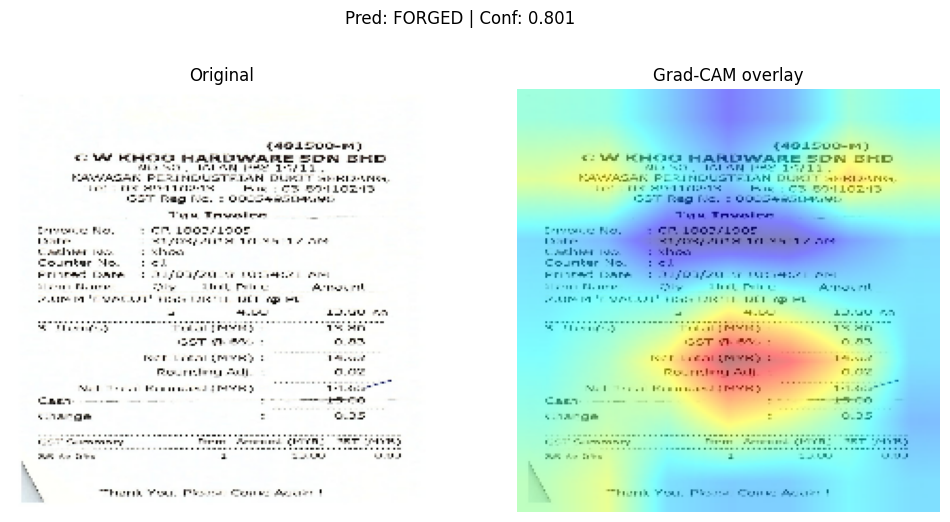

In [11]:
# Test Grad-CAM
from pytorch_grad_cam import GradCAM

df = pd.read_csv("test.csv")
print("Total test samples:", len(df))

sample = df.sample(1).iloc[0]
img_path = sample['image_path']
print("Using:", img_path)

pred, prob, tensor_img, display_img = predict_single_image(img_path)

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=tensor_img, targets=None, aug_smooth=False, eigen_smooth=False)[0]

from pytorch_grad_cam.utils.image import show_cam_on_image
cam_img = show_cam_on_image(display_img, grayscale_cam, use_rgb=True)

show_orig_and_cam(display_img, cam_img, title=f"Pred: {'FORGED' if pred==1 else 'GENUINE'} | Conf: {prob:.3f}")


In [14]:
# Save heatmap images
out_folder = "/content/drive/MyDrive/document-forgery-detection/gradcam_outputs"
import os
os.makedirs(out_folder, exist_ok=True)

save_path = os.path.join(out_folder, os.path.basename(img_path).replace(".png","_cam.png"))
import imageio
imageio.imwrite(save_path, cam_img)
print("Saved heatmap to:", save_path)


Saved heatmap to: /content/drive/MyDrive/document-forgery-detection/gradcam_outputs/X51006350737_cam.png


In [16]:
import streamlit as st
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
from io import BytesIO
import os
import traceback
import zipfile
import gdown
import plotly.graph_objects as go
from fpdf import FPDF
import tempfile
import matplotlib.cm as cm

# --------- Theme & CSS ----------
if "theme_mode" not in st.session_state:
    st.session_state.theme_mode = "Dark"  # Default

def set_theme_css(mode):
    if mode == "Dark":
        css = """
        body, .stApp {
            background-color: #121517 !important;
            color: #e4e9ee !important;
            font-family: 'Montserrat', sans-serif;
        }
        a {
            color: #60c1e3 !important;
            transition: color 0.4s ease;
        }
        h1, h2, h3, h4, h5, h6 {
            color: #70c1b3 !important;
            font-weight: 700;
        }
        .result-card {
            background: #21252b !important;
            box-shadow: 0 4px 32px #003e9622 !important;
            border-radius: 1.1em !important;
            padding: 1.25em 1.4em 1em 1.4em !important;
            margin-bottom: 1.1em !important;
            transition: background-color 0.4s ease;
        }
        .stButton>button {
            color: #fff !important;
            background: linear-gradient(90deg,#007BFF 60%,#5f61e6 100%) !important;
            border: none !important;
            border-radius: .35em !important;
            font-weight: 600 !important;
            font-size: 1.1em !important;
            transition: background 0.3s ease;
        }
        .stButton>button:hover {
            background: linear-gradient(90deg,#5f61e6 60%,#007BFF 100%) !important;
            cursor: pointer;
        }
        [data-testid="stSidebar"] {
            background-color: #21252b !important;
            color: #e4e9ee !important;
        }
        [data-testid="stSidebar"] .stTextInput>div>div>input {
            background-color: #2a2e37 !important;
            color: #e4e9ee !important;
            border: none !important;
            border-radius: 0.3em !important;
        }
        .stFileUploader {
            background-color: #21252b !important;
            border-radius: 0.5em !important;
            padding: 1em !important;
            transition: background-color 0.4s ease;
        }
        ::-webkit-scrollbar {
            width: 8px !important;
        }
        ::-webkit-scrollbar-track {
            background: #181a1f !important;
        }
        ::-webkit-scrollbar-thumb {
            background-color: #3d3f47 !important;
            border-radius: 10px !important;
            border: 2px solid #181a1f !important;
        }
        body, .stApp, .result-card:hover {
            transition: background-color 0.4s ease, color 0.4s ease;
        }
        """
    else:
        css = """
        body, .stApp {
            background-color: #f9f9f9 !important;
            color: #141414 !important;
            font-family: 'Montserrat', sans-serif;
        }
        a {
            color: #007bff !important;
            transition: color 0.4s ease;
        }
        h1, h2, h3, h4, h5, h6 {
            color: #2563eb !important;
            font-weight: 700;
        }
        .result-card {
            background: #ffffff !important;
            box-shadow: 0 4px 32px #aaa !important;
            border-radius: 1.1em !important;
            padding: 1.25em 1.4em 1em 1.4em !important;
            margin-bottom: 1.1em !important;
            transition: background-color 0.4s ease;
        }
        .stButton>button {
            color: #fff !important;
            background: linear-gradient(90deg,#007bff 60%,#5a86ff 100%) !important;
            border: none !important;
            border-radius: .35em !important;
            font-weight: 600 !important;
            font-size: 1.1em !important;
            transition: background 0.3s ease;
        }
        .stButton>button:hover {
            background: linear-gradient(90deg,#5a86ff 60%,#007bff 100%) !important;
            cursor: pointer;
        }
        [data-testid="stSidebar"] {
            background-color: #ffffff !important;
            color: #141414 !important;
        }
        [data-testid="stSidebar"] .stTextInput>div>div>input {
            background-color: #fafafa !important;
            color: #141414 !important;
            border: 1px solid #ddd !important;
            border-radius: 0.3em !important;
        }
        .stFileUploader {
            background-color: #ffffff !important;
            border-radius: 0.5em !important;
            padding: 1em !important;
            transition: background-color 0.4s ease;
        }
        ::-webkit-scrollbar {
            width: 8px !important;
        }
        ::-webkit-scrollbar-track {
            background: #f0f0f0 !important;
        }
        ::-webkit-scrollbar-thumb {
            background-color: #b0b0b0 !important;
            border-radius: 10px !important;
            border: 2px solid #f0f0f0 !important;
        }
        body, .stApp, .result-card:hover {
            transition: background-color 0.4s ease, color 0.4s ease;
        }
        """
    st.markdown(f"<style>{css}</style>", unsafe_allow_html=True)

theme_choice = st.sidebar.radio("Select Theme", ["Light", "Dark"], index=1, key="theme_mode")
set_theme_css(theme_choice)

# -----------  layout and cards -----------

st.set_page_config(layout="wide")
st.markdown("""
<style>
.result-card {
    background: #21252b;
    border-radius: 16px;
    padding: 28px;
    max-width: 980px !important;
    width: 96vw !important;
    margin-left: auto;
    margin-right: auto;
    font-size: 1.14em;
    box-shadow: 0 6px 24px rgba(0,0,0,0.18);
    transition: transform 0.3s ease, box-shadow 0.3s ease;
    cursor: pointer;
    margin-bottom: 1.2em;
}
.result-card:hover {
    transform: translateY(-7px);
    box-shadow: 0 14px 34px rgba(0,123,255,0.15);
}
.stButton>button {
    background: linear-gradient(90deg, #3b82f6 60%, #2563eb 100%);
    border: none;
    border-radius: 10px;
    color: white;
    font-weight: bold;
    font-size: 1.15em;
    padding: 12px 28px;
    transition: background 0.3s ease, transform 0.2s ease;
}
.stButton>button:hover {
    background: linear-gradient(90deg, #2563eb 60%, #3b82f6 100%);
    transform: scale(1.06);
}
.hover-zoom img {
    transition: transform 0.3s ease;
    border-radius: 15px;
}
.hover-zoom:hover img {
    transform: scale(1.05);
}
.stPlotlyChart > div {
    margin-left: auto !important;
    margin-right: auto !important;
}
</style>
""", unsafe_allow_html=True)

# -----------  ML and UI -----------

IMG_SIZE = 224
MODEL_PATH = "models/best_resnet50.pth"
FALLBACK_GDRIVE_ID = "1w4EufvzDfAeVpvL7hfyFdqOce67XV8ks"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGENET_MEAN, IMAGENET_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
MAX_HEIGHT, MAX_WIDTH = 600, 480


def download_model_if_missing(gdrive_id):
    if os.path.exists(MODEL_PATH): return True
    if not gdrive_id: return False
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    url = f"https://drive.google.com/uc?id={gdrive_id}"
    try:
        st.info("📥 Downloading model from Google Drive ...")
        gdown.download(url, MODEL_PATH, quiet=False)
        return os.path.exists(MODEL_PATH)
    except Exception as e:
        st.error(f"Model download failed: {e}")
        return False

@st.cache_resource(show_spinner=True)
def load_model():
    try:
        drive_id = None
        try:
            drive_id = st.secrets.get("MODEL_GDRIVE_ID", None)
        except:
            pass
        if not os.path.exists(MODEL_PATH):
            if not download_model_if_missing(drive_id) and not download_model_if_missing(FALLBACK_GDRIVE_ID):
                st.error("Model not found locally and no valid Drive ID available.")
                return None
        ckpt = torch.load(MODEL_PATH, map_location="cpu")
        state_dict = ckpt
        if isinstance(ckpt, dict):
            for key in ("state_dict", "model_state_dict", "net", "state"):
                if key in ckpt and isinstance(ckpt[key], dict):
                    state_dict = ckpt[key]
                    break
            if state_dict is ckpt and any(k.endswith(".weight") for k in ckpt.keys()):
                state_dict = ckpt
        new_state = {k.replace("module.", ""): v for k, v in state_dict.items()}
        out_features = new_state.get("fc.weight", torch.empty((2,))).shape[0] if "fc.weight" in new_state else 2
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, out_features)
        model.load_state_dict(new_state, strict=False)
        model.to(DEVICE).eval()
        return model
    except Exception as e:
        st.error(f"Failed to load model: {e}")
        st.text(traceback.format_exc())
        return None

def pil_to_tensor(img_pil):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    return transform(img_pil).unsqueeze(0).to(DEVICE)

def predict_single(model, input_tensor):
    with torch.no_grad():
        out = model(input_tensor).to(torch.float32)
        if out.shape[1] == 1:
            prob = torch.sigmoid(out)[0, 0].item()
            return ("FORGED", prob, out) if prob >= 0.5 else ("GENUINE", 1.0 - prob, out)
        probs = torch.softmax(out, dim=1)[0]
        idx = int(torch.argmax(probs))
        return ("FORGED" if idx == 1 else "GENUINE", float(probs[idx]), out)

def compute_gradcam(model, input_tensor, target_layer=None):
    activations, gradients = [], []
    if target_layer is None: target_layer = model.layer4[-1]
    def forward_hook(m, i, o): activations.append(o.detach().cpu())
    def backward_hook(m, gi, go): gradients.append(go[0].detach().cpu())
    fh = target_layer.register_forward_hook(forward_hook)
    try:
        bh = target_layer.register_full_backward_hook(lambda m, gi, go: backward_hook(m, gi, go))
    except:
        bh = target_layer.register_backward_hook(lambda m, gi, go: backward_hook(m, gi, go))
    model.zero_grad()
    out = model(input_tensor)
    score = out[:, 0].sum() if out.shape[1] == 1 else out[0, int(torch.argmax(out, dim=1))]
    score.backward()
    grads, acts = gradients[0].squeeze(0), activations[0].squeeze(0)
    weights = grads.mean(dim=(1, 2))
    cam = np.maximum((weights[:, None, None] * acts).sum(dim=0).numpy(), 0)
    cam_img = Image.fromarray((255 * ((cam - cam.min()) / (cam.max() - cam.min() + 1e-8))).astype(np.uint8))
    cam_img = cam_img.resize((IMG_SIZE, IMG_SIZE))
    cam_norm = np.array(cam_img) / 255.0
    return cam_norm

def overlay_heatmap_on_pil(pil_img, cam, alpha=0.4):
    pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE)).convert("RGBA")
    heatmap_uint8 = (cam * 255).astype(np.uint8)
    colormap = cm.get_cmap("jet")
    heatmap_rgba = colormap(heatmap_uint8 / 255.0, bytes=True)
    heatmap_img = Image.fromarray(heatmap_rgba, mode="RGBA")
    heatmap_img.putalpha(int(255 * alpha))
    composed = Image.alpha_composite(pil_img, heatmap_img)
    return composed.convert("RGB")

def resize_for_display(pil_img, max_width=MAX_WIDTH, max_height=MAX_HEIGHT):
    w, h = pil_img.size
    scale = min(max_width / w, max_height / h)
    return pil_img.resize((int(w * scale), int(h * scale)))

def generate_pdf_report(original_img, gradcam_img, prediction, confidence):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(0, 10, "Receipt Forgery Detection Report", 0, 1, 'C')
    pdf.ln(5)
    pdf.set_font("Arial", '', 12)
    pdf.cell(0, 10, f"Prediction: {prediction}", 0, 1)
    pdf.cell(0, 10, f"Confidence: {confidence:.2%}", 0, 1)
    pdf.ln(10)
    with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as orig_tmp, tempfile.NamedTemporaryFile(suffix=".png", delete=True) as gradcam_tmp:
        original_img.save(orig_tmp.name)
        gradcam_img.save(gradcam_tmp.name)
        pdf.image(orig_tmp.name, x=10, y=50, w=80)
        pdf.image(gradcam_tmp.name, x=110, y=50, w=80)
        return pdf.output(dest='S').encode('latin1')

def draw_confidence_gauge(confidence, label):
    color = "#30e394" if label == "GENUINE" else "#ff5264"
    arrow_color = "#30e394" if label == "GENUINE" else "#ff5264"
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=round(confidence * 100),
        title={'text': "Confidence", "font": {"size": 32}},
        number={"suffix": "%", "font": {"size": 54}},
        delta={"reference": 50, "increasing": {"color": arrow_color}, "decreasing": {"color": arrow_color}, "font": {"size":22}},
        gauge={
            "axis": {"range": [0, 100], "tickwidth": 2, "tickcolor": "#cbd5e1"},
            "bar": {"color": color, "thickness": 0.38},
            "bgcolor": "#f6f7fa",
            "borderwidth": 2,
            "bordercolor": "#e2e8f0",
            "steps": [
                {"range": [0, 50], "color": "#fee2e2"},
                {"range": [50, 100], "color": "#d1e7dd"},
            ],
            "threshold": {
                "line": {"color": color, "width": 8},
                "thickness": 0.85,
                "value": confidence * 100,
            }
        }
    ))
    fig.update_layout(
        margin=dict(t=0, b=0, l=0, r=0),
        width=370, height=340,
        paper_bgcolor="#f8fafc"
    )
    st.plotly_chart(fig, use_container_width=True)

# ----------- App heading  -----------
st.markdown("""
    <div style='display:flex;align-items:center;justify-content:space-between;padding:1.3em 2.2em 1em 0em;background:rgba(8,16,32,0.12);border-radius:22px;margin-bottom:1.5em;font-family: Montserrat, sans-serif;'>
        <div style='font-weight:700;font-size:2em;letter-spacing:1px; color:#60c1e3;'>🧾 Receipt Forgery Detector</div>
        <a style='color:#60c1e3;text-decoration:none;font-size:1.15em;' href='https://github.com/Sridharan777' target='_blank'>GitHub</a>
    </div>
""", unsafe_allow_html=True)

st.markdown("<p style='color:#d1d5db;font-size:1.23em;margin-bottom:1.7em;font-weight:500;'>Upload receipt image(s) to detect forgery with deep learning and visual Grad-CAM explanations.</p>", unsafe_allow_html=True)

# ----------- Upload and history -----------
if "upload_history" not in st.session_state:
    st.session_state.upload_history = []
if "feedback" not in st.session_state:
    st.session_state.feedback = {}

uploaded_files = st.file_uploader("Receipt image(s)", type=["png", "jpg", "jpeg"], accept_multiple_files=True)
if uploaded_files:
    for f in uploaded_files:
        if f.name not in st.session_state.upload_history:
            st.session_state.upload_history.append(f.name)

with st.sidebar.expander("Upload History 🕒", expanded=False):
    if st.session_state.upload_history:
        for fname in st.session_state.upload_history:
            st.markdown(f"• {fname}", unsafe_allow_html=True)
    else:
        st.write("No upload history yet.")

# ----------- Model loading -----------
with st.spinner("🧠 Loading detection model, please wait..."):
    model = load_model()
if model is None:
    st.stop()

# ----------- Prediction and display -----------
if uploaded_files:
    overlay_buffers = []
    tabs = st.tabs([f"Receipt {i+1}" for i in range(len(uploaded_files))])
    progress_bar = st.progress(0)
    for i, (uploaded, tab) in enumerate(zip(uploaded_files, tabs)):
        with tab:
            pil_img = Image.open(uploaded).convert("RGB")
            resized_img = resize_for_display(pil_img)
            input_tensor = pil_to_tensor(pil_img)
            with st.spinner(f"Processing {uploaded.name} ..."):
                label, confidence, raw_out = predict_single(model, input_tensor)
                cam = compute_gradcam(model, input_tensor)
                overlay = overlay_heatmap_on_pil(pil_img, cam)
                overlay_resized = overlay.resize(resized_img.size)
            buf = BytesIO()
            overlay_resized.save(buf, format="PNG")
            overlay_buffers.append((f"gradcam_{i+1}.png", buf.getvalue()))
            st.markdown('<div class="result-card">', unsafe_allow_html=True)
            col1, col2, col3 = st.columns([1.2, 1.1, 1.2], gap="medium")
            with col1:
                st.markdown('<div class="hover-zoom">', unsafe_allow_html=True)
                st.image(resized_img, caption="Original Receipt", use_container_width=True)
                st.markdown('</div>', unsafe_allow_html=True)
            with col2:
                st.markdown('<div class="hover-zoom">', unsafe_allow_html=True)
                st.image(overlay_resized, caption="Grad-CAM", use_container_width=True)
                st.markdown('</div>', unsafe_allow_html=True)
            with col3:
                st.markdown(f"""
                    <div style='text-align:center; font-size:2em; font-weight:700; color:#60c1e3; letter-spacing:1px; margin-bottom:0.3em;'>
                        🏆 Prediction Result
                    </div>
                    <div style='text-align:center; font-size:1.5em; font-weight:600; color:{ '#30e394' if label=='GENUINE' else '#ff5264' }; margin-bottom:0.3em;'>
                        {label} { '✓' if label == 'GENUINE' else '⚠️' }
                    </div>
                """, unsafe_allow_html=True)
                draw_confidence_gauge(confidence, label)
                st.markdown("<br>", unsafe_allow_html=True)
                st.download_button(
                    "Download PDF Report",
                    generate_pdf_report(pil_img, overlay_resized, label, confidence),
                    file_name=f"report_{i+1}.pdf",
                    mime="application/pdf"
                )
            st.markdown('</div>', unsafe_allow_html=True)
            st.caption("Switch tabs to view more receipts or download Grad-CAM images.")
            progress_bar.progress((i + 1) / len(uploaded_files))
    progress_bar.empty()
    zip_buffer = BytesIO()
    with zipfile.ZipFile(zip_buffer, "w") as zipf:
        for fname, data in overlay_buffers:
            zipf.writestr(fname, data)
    st.download_button("Download ALL Overlays (ZIP)", zip_buffer.getvalue(), file_name="all_gradcams.zip", mime="application/zip")

st.markdown("""
    <div style='text-align:center; padding-top:2em; font-size:1.15em; color:#8585a1; font-family: Montserrat, sans-serif;'>
        Built with ❤️ using Streamlit • <a href="https://github.com/Sridharan777" style='color:#60c1e3;' target="_blank">Source on GitHub</a>
    </div>
""", unsafe_allow_html=True)

Overwriting app.py
